In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder  
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE  
from geopy.distance import geodesic
import joblib

In [2]:
df=pd.read_csv('dataset.csv')

In [3]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [4]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

df['hour'] = df['trans_date_trans_time'].dt.hour
df['day'] = df['trans_date_trans_time'].dt.day
df['month'] = df['trans_date_trans_time'].dt.month

In [7]:
print(df.columns.tolist())


['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud', 'hour', 'day', 'month']


In [17]:
# Check the actual column names
print(df.columns.tolist())

# Clean up column names
df.columns = df.columns.str.strip()  # Remove any leading or trailing spaces

# Define the columns to drop
drop_columns = ['Unnamed: 0', 'trans_date_trans_time', 'first', 'last', 'street', 'city', 'state', 'zip', 'dob', 'job', 'trans_num']

# Drop the specified columns, ignoring any that are not found
df = df.drop(columns=drop_columns, errors='ignore')


['cc_num', 'merchant', 'category', 'amt', 'gender', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud', 'hour', 'day', 'month']


In [49]:
df.head()

,cc_num,merchant,category,amt,gender,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,hour,day,month,distance
0,2703186189652095,514,8,4.97,0,36.0788,-81.1781,3495,1325376018,36.011293,-82.048315,0,0,1,1,78.773821
1,630423337322,241,4,107.23,0,48.8878,-118.2105,149,1325376044,49.159047,-118.186462,0,0,1,1,30.216618
2,38859492057661,390,0,220.11,1,42.1808,-112.2620,4154,1325376051,43.150704,-112.154481,0,0,1,1,108.102912
3,3534093764340240,360,2,45.00,1,46.2306,-112.1138,1939,1325376076,47.034331,-112.561071,0,0,1,1,95.685115
4,375534208663984,297,9,41.96,1,38.4207,-79.4629,99,1325376186,38.674999,-78.632459,0,0,1,1,77.702395


In [19]:
categorical_columns=['merchant','category','gender']
encoder={}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoder[col] = le  # Store the encoder for later use


In [27]:
# Define the haversine distance function 
# This function calculates the distance between two points on the Earth given their latitude and longitude
# The haversine formula is used to calculate the distance between two points on the surface of a sphere
def haversine_distance(lat1, lon1, lat2, lon2):
    return np.array([geodesic((lat1, lon1), (lat2, lon2)).km for lat1, lon1, lat2, lon2 in zip(lat1, lon1, lat2, lon2)])

# Assuming df is your DataFrame with the necessary columns
df['distance'] = haversine_distance(df['lat'], df['long'], df['merch_lat'], df['merch_long'])
  

In [30]:
# distance column is added to the DataFrame
# Check the DataFrame to see if the distance column has been added correctly
df.head()

,cc_num,merchant,category,amt,gender,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,hour,day,month,distance
0,2703186189652095,514,8,4.97,0,36.0788,-81.1781,3495,1325376018,36.011293,-82.048315,0,0,1,1,78.773821
1,630423337322,241,4,107.23,0,48.8878,-118.2105,149,1325376044,49.159047,-118.186462,0,0,1,1,30.216618
2,38859492057661,390,0,220.11,1,42.1808,-112.2620,4154,1325376051,43.150704,-112.154481,0,0,1,1,108.102912
3,3534093764340240,360,2,45.00,1,46.2306,-112.1138,1939,1325376076,47.034331,-112.561071,0,0,1,1,95.685115
4,375534208663984,297,9,41.96,1,38.4207,-79.4629,99,1325376186,38.674999,-78.632459,0,0,1,1,77.702395


In [28]:
features= ['merchant', 'category','amt','cc_num','hour','day','month','gender','distance']
x=df[features]
y=df['is_fraud']

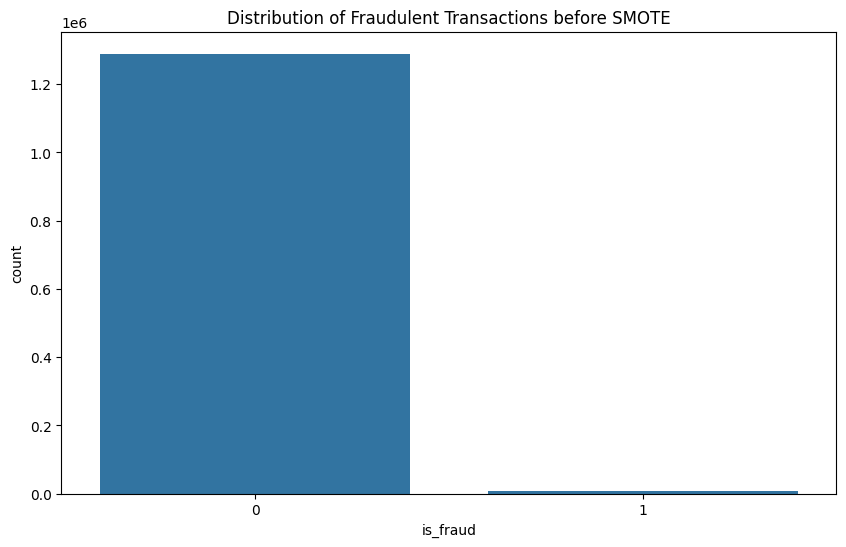

In [31]:
# to check imbalance data of fraud and non-fraud
plt.figure(figsize=(10, 6))
sns.countplot(x='is_fraud', data=df)
plt.title('Distribution of Fraudulent Transactions before SMOTE')
plt.show()


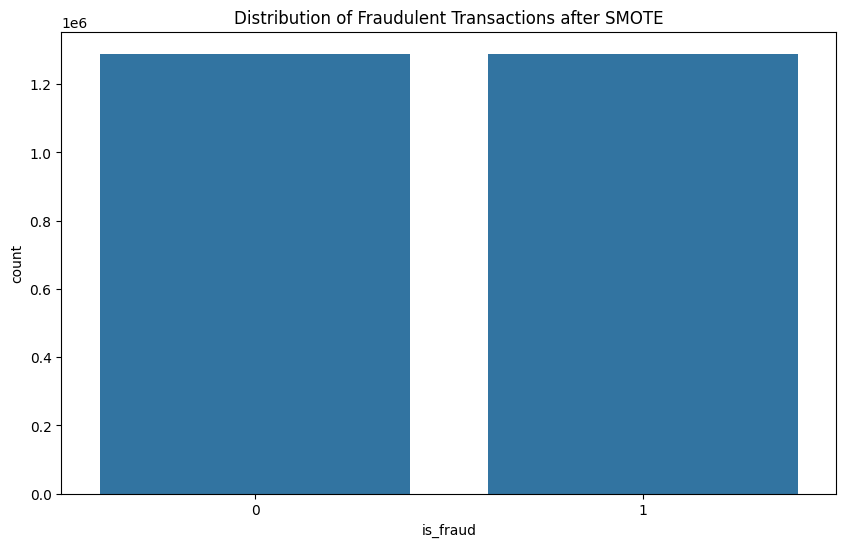

In [32]:
# applying SMOTE to balance the dataset
smote = SMOTE(random_state=42)  
x_resampled, y_resampled = smote.fit_resample(x, y)
# Check the distribution of the resampled data  
plt.figure(figsize=(10, 6))
sns.countplot(x=y_resampled)
plt.title('Distribution of Fraudulent Transactions after SMOTE')  
plt.show()

## splitting the data into train and test sets

In [35]:
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=42)




In [41]:
lgb_model = lgb.LGBMClassifier(
  boosting_type='gbdt',
  objective='binary', 
  metric='auc',
  num_leaves=31,
  learning_rate=0.05,
  is_balanced=True,
  max_depth=1,
  n_estimators=200,
)
lgb_model.fit(x_train, y_train) 


[LightGBM] [Warning] Unknown parameter: is_balanced
[LightGBM] [Warning] Unknown parameter: is_balanced
[LightGBM] [Info] Number of positive: 1030687, number of negative: 1031983
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 2062670, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499686 -> initscore=-0.001257
[LightGBM] [Info] Start training from score -0.001257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

LGBMClassifier(is_balanced=True, learning_rate=0.05, max_depth=1, metric='auc',
               n_estimators=200, objective='binary')

In [42]:
y_pred = lgb_model.predict(x_test)

[LightGBM] [Warning] Unknown parameter: is_balanced


In [43]:
print("classification_report:\n", classification_report(y_test,y_pred))
print("Roc_auc_score:", roc_auc_score(y_test,y_pred))


classification_report:
               precision    recall  f1-score   support

           0       0.82      0.95      0.88    257186
           1       0.95      0.79      0.86    258482

    accuracy                           0.87    515668
   macro avg       0.88      0.87      0.87    515668
weighted avg       0.88      0.87      0.87    515668

Roc_auc_score: 0.870522108231338


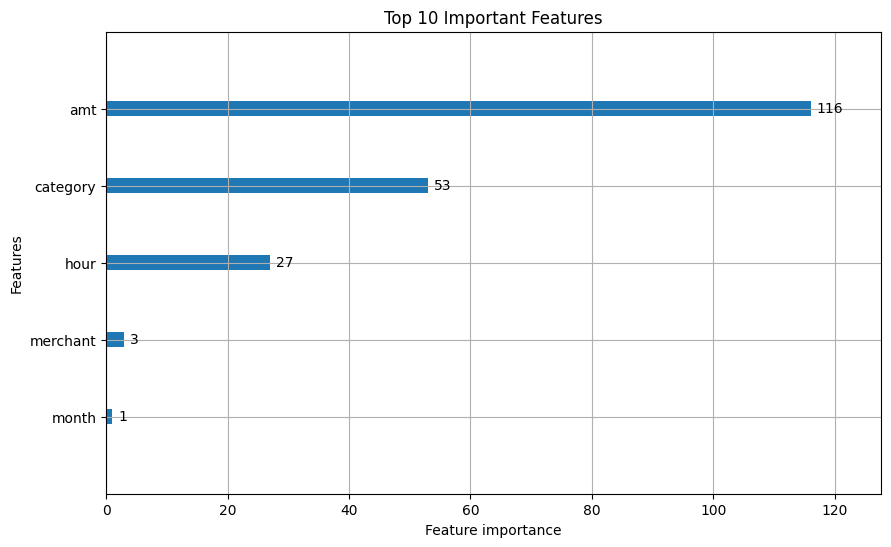

In [45]:
lgb.plot_importance(lgb_model, max_num_features=10, importance_type='split', figsize=(10, 6))
plt.title('Top 10 Important Features')
plt.show()

[LightGBM] [Warning] Unknown parameter: is_balanced


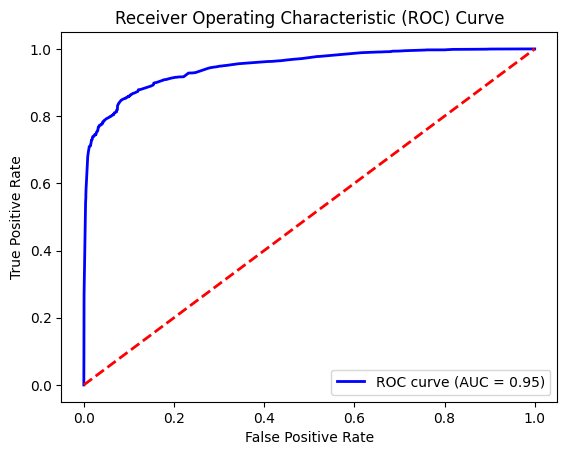

In [46]:
fpr, tpr, thresholds = roc_curve(y_test, lgb_model.predict_proba(x_test)[:, 1])
roc_auc= auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue', lw =2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [47]:
joblib.dump(lgb_model, 'fraud_detection_model.jb')  # Save the model to a file
joblib.dump(encoder, 'label_encoders.jb')  # Save the encoders to a file

['label_encoders.jb']